# Gaussian Process Regression

## Introduction

A surrogate model is an engineering method used when an outcome of interest cannot be easily directly measured, so a model of the outcome is used instead. Most engineering design problems require experiments and/or simulations to evaluate design objective and constraint functions as function of the design variables. For example, in order to find the optimal airfoil shape for an aircraft wing, an engineer simulates the air flow around the wing for different shape variables (length, curvature, material, ...). For many real world problems, however, a single simulation can take many minutes, hours, or even days to complete. As a result, routine tasks such as design optimization, design space exploration, sensitivity analysis become near impossible since they require a great number of function evaluations.

One way of alleviating this burden is by constructing approximation models, known as surrogate models, response surface models, metamodels or emulators, that mimic the behavior of the simulation model as closely as possible while being computationally cheaper to evaluate. Surrogate models are constructed using a data-driven approach. The exact, inner working of the simulation code is not assumed to be known (or even understood), solely the input-output behavior is important.

There exists multiple ways to build an approximation of a function: Artificial Neural Networks, Radial Basis Functions, Support Vector Regressions... 
In all these metamodels (or surrogate models), a fundamental assumption is that the quantity of interest $y(x)$ can be written $y(x) = \hat{y}(x) + \epsilon$, where $\epsilon$, the residuals, are independent identically distributed normal random variables, so that fitting the model $\hat{y}(x)$ is performed by minimizing a measure over $\epsilon$.

Please have a look to this airfoil optimization tool : 
http://mdolab.engin.umich.edu/webfoil/}{http://mdolab.engin.umich.edu/webfoil/

It has been constructed by lot of offline computations and an excellent tool developed jointly by University of Michigan, Nasa, Onera and SUPAERO called SMT.

https://github.com/SMTorg/SMT}{https://github.com/SMTorg/SMT

The author really encourage SUPAERO's student to have a look to classical textbooks such as (Rasmussen, 2004) for Machine learning community and (Forrester, 2008) for aerospace engineering community.

## I. Gaussian Process Regression

The main idea behind Kriging is that the 'errors' -or more accurately, the deviations from the base model- in the predicted values $\hat{y}$, are not independent. Rather, we take the view that the errors are a systematic function of the locations of the samples.

Please connect to your course lesson on GPR: https://github.com/erachelson/MLclass/blob/master/5%-%Gaussian%Processes/Gaussian%Processes.ipynb

We wish to train a GPR model $\mathcal{G} = \lbrace \mathbf{X}, \mathbf{Y}, \theta \rbrace$ using the Squared Exponential function so called SE Kernel $k(x,x') =\sigma_f^2\exp\left(-\frac{(x-x')^2}{l^ 2}\right)$.

Given the input data $\mathbf{y} = \left[y_1,\ldots,y_N\right]$ and $\mathbf{x} =  \left[x_1,\ldots,x_N\right]$, and given a covariance kernel $k(x,x')$, a Gaussian Process regressor estimates the distribution of $y(x)$ as a Gaussian $\mathcal{N}(\mu,\sigma)$ with: $\mu = K_*(x)K^{-1} \mathbf{y}$, $\sigma(y)^2 = k(x,x) - K_*(x)K^{-1}K_*(x)^T$, where:

$$K =
\begin{bmatrix}
k(x_1,x_1) & \ldots & k(x_1,x_N) \\
\vdots     & \ddots & \vdots \\
k(x_1,x_N) & \ldots & k(x_N,x_N)
\end{bmatrix}, \
K_*(x) = \left[k(x_1, x), \ldots, k(x_N,x)\right]$$

On the 1D example $f(x)= (x-3.5)\sin{\frac{(x-3.5)}{\Pi}}$ on $\left [ 0, 25\right ]$, we will have a naive approach.

<IPython.core.display.Javascript object>


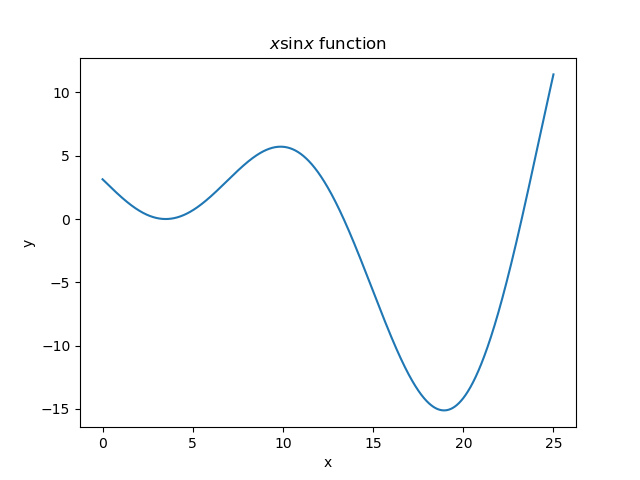

In [81]:
import numpy as np 
%matplotlib notebook
import matplotlib.pyplot as plt

plt.ion()

def fun(point):
    return np.atleast_2d((point-3.5)*np.sin((point-3.5)/(np.pi)))

X_plot = np.atleast_2d(np.linspace(0, 25, 10000)).T
Y_plot = fun(X_plot)
#y_gpr , y_std = gpr.predict(X_plot , return_std=True)

lines = []
fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
lines.append(true_fun)
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [95]:
def cov_function(point_1,point_2,theta,sig):
    theta = np.asarray(theta)
    size = point_1.shape
    dist = (point_1-point_2)**2.
    k_12 = (sig**2.) * np.exp(- np.sum(dist / theta**2.))
    return k_12

def cov_matrix(points,theta,sig):
    theta = np.asarray(theta)
    size = points.shape
    K = np.zeros((size[0],size[0]))
    for i,point in enumerate(points):
        K[:,i] = np.array([cov_function(point,point_1,theta,sig) for point_1 in points])
    return K

def cov_vect(point,points,theta,sig):
    theta = np.asarray(theta)
    size = points.shape
    K = np.array([cov_function(point,point_1,theta,sig) for point_1 in points])
    return K

### Question 1:

1.1 Code the function that predict the mean and the standard deviation of the Gaussian process using the previous defined function

In [96]:
def myGPpredict(x_new, x_data, y_data, K_inv, theta, sig):
    # Code Here
    K_et = cov_vect(x_new,x_data,theta,sig)
    mu = K_et.dot(K_inv.dot(y_data))
    k_xx = cov_function(x_new,x_new,theta,sig)
    sigma = k_xx - K_et.dot(K_inv.dot(K_et.T))
    return mu[0],sigma

1.2 Test several values of $\theta = [l, \sigma_f]$ with  $l$ defined as the length-scale  (of oscillations) and  $\sigma_f$ the amplitude. Look at the RMSE and R2 score that give an inforamtion on the accuracy of the model. RMSE must be close to 0 and R2 must be close to 1. For more information about this metrics, look at https://en.wikipedia.org/wiki/Root-mean-square_deviation and https://en.wikipedia.org/wiki/Coefficient_of_determination

<IPython.core.display.Javascript object>


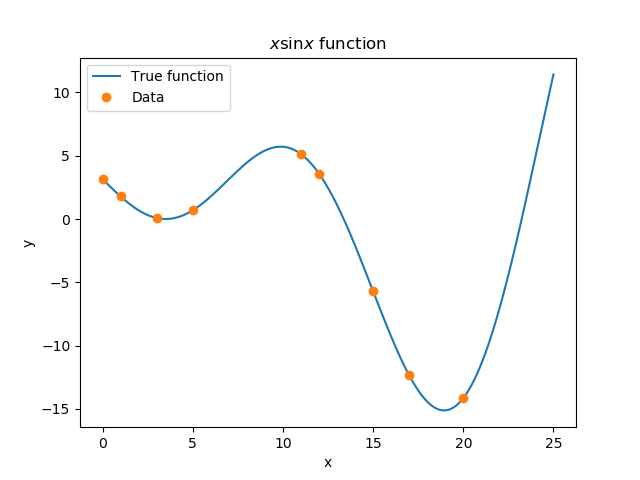

In [97]:
from sklearn.metrics import mean_squared_error, r2_score

x_test = np.atleast_2d(np.linspace(0,25,100)).T
y_test = fun(x_test)

x_data = np.atleast_2d([0,11,20,1,5,15,12,3,17]).T
y_data = fun(x_data)


X_plot = np.atleast_2d(np.linspace(0,25,1000)).T
Y_plot = fun(X_plot)

lines = []
fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
lines.append(true_fun)
lines.append(data)
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(lines,['True function','Data'])
plt.show()

RMSE = 8.44919
R2 = 0.82962


<IPython.core.display.Javascript object>


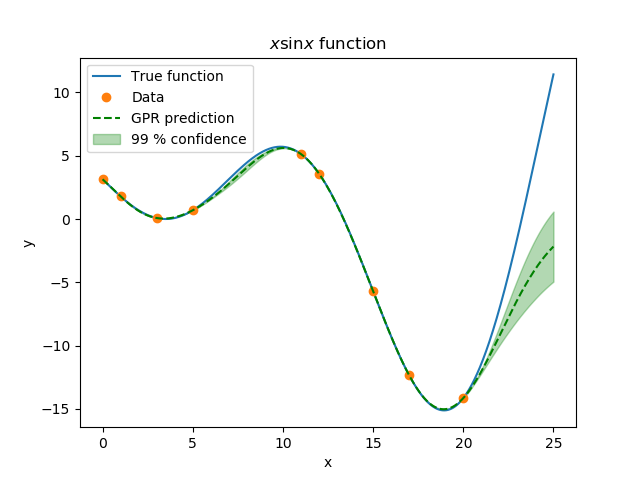

In [99]:
l = [4]
sig = 1

K = cov_matrix(x_data,l,sig)
K_inv = np.linalg.inv(K)

### Faire avec la cross validation
## Pas vu les plan d'experience 

y_pred = np.array([myGPpredict(x_t,x_data,y_data,K_inv,l,sig) \
                   for x_t in x_test])

RMSE = mean_squared_error(y_test,y_pred[:,0])
R2 = r2_score(y_test,y_pred[:,0])
print('RMSE = %.5f' %(RMSE)) 
print('R2 = %.5f' %(R2))

Y_GP_plot = np.array([myGPpredict(x_t,x_data,y_data,K_inv,l,sig) \
                   for x_t in X_plot])

fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
gp, = ax.plot(X_plot,Y_GP_plot[:,0],linestyle='--',color='g')
un_gp = ax.fill_between(X_plot.T[0],Y_GP_plot[:,0]+3*Y_GP_plot[:,1],Y_GP_plot[:,0]-3*Y_GP_plot[:,1],alpha=0.3,color='g')
lines = [true_fun,data,gp,un_gp]
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(lines,['True function','Data','GPR prediction','99 % confidence'])
plt.show()

1.3 Conclude: Is there a way to find $\theta_{optimal} = \theta*$

Answer : 

## II. Hyperparameters Optimization

To train the model, the negative log marginal likelihood with respect to the hyper-parameters is minimized:
$-2\text{log}\, p(\mathbf{Y} \mid \mathbf{X}, \theta) = \mathbf{Y}^\top\mathbf{K}^{-1}\mathbf{Y} + \log\mid\mathbf{K}\mid + \log(2\pi),$
where the matrix $\mathbf{K}$ is a function of the hyper-parameters 

### Question 2:

2.1 Code the Marginal Likelyhood function of $l \in [10^{-3},25]$ at $\sigma_f=1$ fixed.

<IPython.core.display.Javascript object>


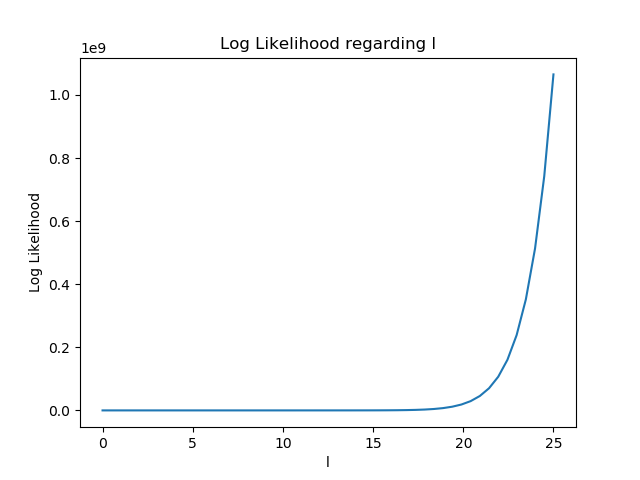

Text(0.5,1,'Log Likelihood regarding l')

In [117]:
def likelihood(x_data,y_data,l,sig):
    K = cov_matrix(x_data,l,sig)
    args1 = y_data.T.dot(np.linalg.inv(K))
    args2 = args1.dot(y_data)
    args3 =  np.log(np.linalg.det(K))
    like = args2 + args3 + x_data.shape[1]*np.log(2*np.pi)
    return like[0,0]

theta = np.linspace(1e-3,25)

like = np.array([likelihood(x_data,y_data,th,sig) for th in theta])

fig = plt.figure()
ax = fig.add_subplot(111)
line = ax.plot(theta,like)
ax.set_xlabel('l')
ax.set_ylabel('Log Likelihood')
ax.set_title('Log Likelihood regarding l')

2.2 Optimize the Marginal Likelihood function to find $l^*$. Pay attention: some optimizers are gradient based and converged to a local optimum.

In [118]:
from scipy.optimize import minimize 

like_obj = lambda l : likelihood(x_data,y_data,l,sig)

# Multistart to remove bad optimization results
l_start = np.linspace(1e-3,25,5)

opt_all = np.array([minimize(like_obj, l, method='SLSQP', bounds=[(1e-3,25)]) for l in l_start])
opt_success = opt_all[[opt_i['success'] for opt_i in opt_all]]
obj_success = np.array([opt_i['fun'] for opt_i in opt_success])
ind_min = np.argmin(obj_success)

opt = opt_success[ind_min]
l_et = opt['x']

print('Optimization results', opt)
print('')
print('Best l is %.5f' %(l_et))

('Optimization results',      fun: 277.85741196439756
     jac: array([-0.00017166])
 message: 'Optimization terminated successfully.'
    nfev: 19
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([4.23607303]))

Best l is 4.23607


## III. Optimization

Now we would like to minimize a black box function subject to boundary constraints. This function is very expensive to evaluate and only provide the output (Meaning that you don't have access to gradient, etc.). We will use Gaussian Process to solve this optimization problem. 

Right now you can use directly scikit-learn which includes all these operations in a single procedure. Here, the data are the points $x_{data} = \left [0, 7, 25 \right ]$. 

## Question 3

3.1 Build the GP model with a square exponential kernel with scikit-learn toolbox knowing $(x_{data}, y_{data})$.

<IPython.core.display.Javascript object>


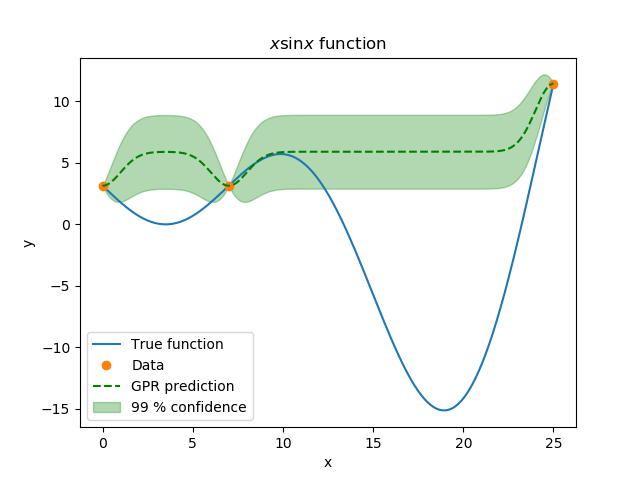

In [119]:
from sklearn.gaussian_process import GaussianProcessRegressor as GP
from sklearn.gaussian_process.kernels import RBF as SEkernel

x_data = np.atleast_2d([0,7,25]).T
y_data = fun(x_data)

ker = SEkernel()
gpr = GP(kernel=ker,n_restarts_optimizer=10,normalize_y=True)

gpr.fit(x_data,y_data)

Y_GP_plot = gpr.predict(X_plot,return_std=True)

fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
gp, = ax.plot(X_plot,Y_GP_plot[0],linestyle='--',color='g')
sig_plus = Y_GP_plot[0]+3*np.atleast_2d(Y_GP_plot[1]).T
sig_moins = Y_GP_plot[0]-3*np.atleast_2d(Y_GP_plot[1]).T
un_gp = ax.fill_between(X_plot.T[0],sig_plus.T[0],sig_moins.T[0],alpha=0.3,color='g')
lines = [true_fun,data,gp,un_gp]
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(lines,['True function','Data','GPR prediction','99 % confidence'])
plt.show()

## Question 4

Each evaluation of the objective function is very expensive: let's say 10 hours. 
Your challenge is: Minimize the $x \sin{(x)}$ function given a total computational budget of 10 points with the initial points $(x_{data},y_{data})$.

4.1 Give at least 2 methods to optimize the true function thanks to Gaussian Process. You don't have to code it explicitly, give the main idea.

Answer: 

## Question 5 : Bayesian Optimization

Bayesian optimization is defined by Jonas Mockus in (Mockus, 1975) as an optimization technique based upon the minimization of the expected deviation from the extremum of the studied function. 

The objective function is treated as a black-box function. A Bayesian strategy sees the objective as a random function and places a prior over it. The prior captures our beliefs about the behavior of the function. After gathering the function evaluations, which are treated as data, the prior is updated to form the posterior distribution over the objective function. The posterior distribution, in turn, is used to construct an acquisition function (often also referred to as infill sampling criterion) that determines what the next query point should be.

One of the earliest bodies of work on Bayesian optimisation that we are aware of is (Kushner, 1962 ; Kushner, 1964). Kushner used Wiener processes for one-dimensional problems. Kushner’s decision model was based on maximizing the probability of improvement, and included a parameter that controlled the trade-off between ‘more global’ and ‘more local’ optimization, in the same spirit as the Exploration/Exploitation trade-off.

Meanwhile, in the former Soviet Union, Mockus and colleagues developed a multidimensional Bayesian optimization method using linear combinations of Wiener fields, some of which was published in English in (Mockus, 1975). This paper also describes an acquisition function that is based on myopic expected improvement of the posterior, which has been widely adopted in Bayesian optimization as the Expected Improvement function.

In 1998, Jones used Gaussian processes together with the expected improvement function to successfully perform derivative-free optimization and experimental design through an algorithm called  Efficient  Global  Optimization, or EGO (Jones, 1998).

### Efficient Global Optimization

In what follows, we describe the Efficient Global Optimization (EGO) algorithm, as published in (Jones, 1998).

Let $F$ be an expensive black-box function to be minimized. We sample $F$ at the different locations  $X = \{x_1, x_2,\ldots,x_n\}$ yielding the responses $Y = \{y_1, y_2,\ldots,y_n\}$. We build a Kriging model (also called Gaussian process) with a mean function $\mu$ and a variance function $\sigma^{2}$.

The next step is to compute the criterion EI. To do this, let us denote:
$$f_{min} = \min \{y_1, y_2,\ldots,y_n\}.$$
The Expected Improvement funtion (EI) can be expressed:
$$E[I(x)] = E[\max(f_{min}-Y, 0)],$$
where $Y$ is the random variable following the distribution $\mathcal{N}(\mu(x), \sigma^{2}(x))$.
By expressing the right-hand side of EI expression as an integral, and applying some tedious integration by parts, one can express the expected improvement in closed form: 
\begin{equation}
E[I(x)] = (f_{min} - \mu(x))\Phi\left(\frac{f_{min} - \mu(x)}{\sigma(x)}\right) + \sigma(x) \phi\left(\frac{f_{min} - \mu(x)}{\sigma(x)}\right)
\label{eq:EI_simp}
\end{equation}
where $\Phi(\cdot)$ and $\phi(\cdot)$ are respectively the cumulative and probability density functions of $\mathcal{N}(0,1)$.

Next, we determine our next sampling point as :
\begin{align}
x_{n+1} = \arg \max_{x} \left(E[I(x)]\right)
\end{align}

We then test the response $y_{n+1}$ of our black-box function $F$ at $x_{n+1}$, rebuild the model taking into account the new information gained, and research the point of maximum expected improvement again.

We summarize here the EGO algorithm:

EGO(F, $n_{iter}$ \# Find the best minimum of $\operatorname{F}$ in $n_{iter}$ iterations  
For ($i=0:n_{iter}$)  

* $mod = {model}(X, Y)$  \# surrogate model based on sample vectors $X$ and $Y$  
* $f_{min} = \min Y$  
* $x_{i+1} = \arg \max {EI}(mod, f_{min})$ \# choose $x$ that maximizes EI  
* $y_{i+1} = {F}(x_{i+1})$ \# Probe the function at most promising point $x_{i+1}$  
* $X = [X,x_{i+1}]$  
* $Y = [Y,y_{i+1}]$   
* $i = i+1$  

$f_{min} = \min Y$  
Return : $f_{min}$ \# This is the best known solution after $n_{iter}$ iterations

5.1 Code the EI criteria

<IPython.core.display.Javascript object>


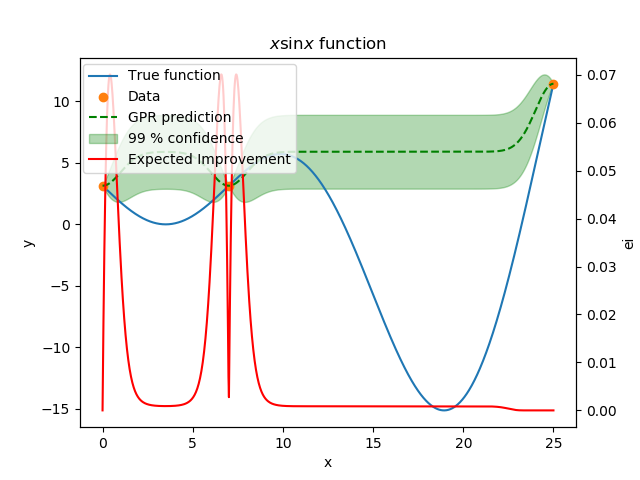

In [120]:
from scipy.stats import norm
 
def EI(GP,points,f_min):
    pred = GP.predict(points,return_std=True)
    args0 = (f_min - pred[0])/np.atleast_2d(pred[1]).T
    args1 = (f_min - pred[0])*norm.cdf(args0)
    args2 = np.atleast_2d(pred[1]).T*norm.pdf(args0)
    ei = args1 + args2
    return ei


Y_GP_plot = gpr.predict(X_plot,return_std=True)
Y_EI_plot = EI(gpr,X_plot,np.min(y_data))

fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
gp, = ax.plot(X_plot,Y_GP_plot[0],linestyle='--',color='g')
sig_plus = Y_GP_plot[0]+3*np.atleast_2d(Y_GP_plot[1]).T
sig_moins = Y_GP_plot[0]-3*np.atleast_2d(Y_GP_plot[1]).T
un_gp = ax.fill_between(X_plot.T[0],sig_plus.T[0],sig_moins.T[0],alpha=0.3,color='g')
ax1 = ax.twinx()
ei, = ax1.plot(X_plot,Y_EI_plot,color='red')
lines = [true_fun,data,gp,un_gp,ei]
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax1.set_ylabel('ei')
fig.legend(lines,['True function','Data','GPR prediction','99 % confidence','Expected Improvement'],loc=[0.13,0.64])
plt.show()

5.2 Complete the code the EGO method and compare it to other infill criteria

In [121]:
import matplotlib.image as mpimg
import matplotlib.animation as animation
from IPython.display import HTML

def SBO(GP,point):
    res = GP.predict(point)
    return res

def UCB(GP,point):
    pred = GP.predict(point,return_std=True)
    res = pred[0]-3.*np.atleast_2d(pred[1]).T
    return res

plt.ioff()

x_data = np.atleast_2d([0,7,25]).T
y_data = fun(x_data)

n_iter = 15
ker = SEkernel()
gpr = gpr = GP(kernel=ker,n_restarts_optimizer=10,normalize_y=True)


IC = 'EI'


for k in range(n_iter):
    x_start = np.atleast_2d(np.random.rand(20)*25).T
    f_min_k = np.min(y_data)
    gpr.fit(x_data,y_data)
    
    if IC == 'EI':
        obj_k = lambda x: -EI(gpr,np.atleast_2d(x),f_min_k)
    elif IC =='SBO':
        obj_k = lambda x: SBO(gpr,np.atleast_2d(x))
    elif IC == 'UCB':
        obj_k = lambda x: UCB(gpr,np.atleast_2d(x))
    
    opt_all = np.array([minimize(obj_k, x_st, method='SLSQP', bounds=[(0,25)]) for x_st in x_start])
    opt_success = opt_all[[opt_i['success'] for opt_i in opt_all]]
    obj_success = np.array([opt_i['fun'] for opt_i in opt_success])
    ind_min = np.argmin(obj_success)
    opt = opt_success[ind_min]
    x_et_k = opt['x']
    
    y_et_k = fun(x_et_k)
    
    y_data = np.atleast_2d(np.append(y_data,y_et_k)).T
    x_data = np.atleast_2d(np.append(x_data,x_et_k)).T
    
    Y_GP_plot = gpr.predict(X_plot,return_std=True)
    Y_EI_plot = obj_k(X_plot)

    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(111)
    if IC == 'UCB' or IC == 'SBO':
        ei, = ax.plot(X_plot,Y_EI_plot,color='red')
    else:    
        ax1 = ax.twinx()
        ei, = ax1.plot(X_plot,Y_EI_plot,color='red')
    true_fun, = ax.plot(X_plot,Y_plot)
    data, = ax.plot(x_data[0:k+3],y_data[0:k+3],linestyle='',marker='o',color='orange')
    opt, = ax.plot(x_data[k+3],y_data[k+3],linestyle='',marker='*',color='r')
    gp, = ax.plot(X_plot,Y_GP_plot[0],linestyle='--',color='g')
    sig_plus = Y_GP_plot[0]+3*np.atleast_2d(Y_GP_plot[1]).T
    sig_moins = Y_GP_plot[0]-3*np.atleast_2d(Y_GP_plot[1]).T
    un_gp = ax.fill_between(X_plot.T[0],sig_plus.T[0],sig_moins.T[0],alpha=0.3,color='g')
    lines = [true_fun,data,gp,un_gp,opt,ei]
    ax.set_title('$x \sin{x}$ function')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(lines,['True function','Data','GPR prediction','99 % confidence','Next point to Evaluate','Infill Criteria'])
    plt.savefig('Optimisation %d' %k)
    plt.close(fig)
    
ind_best = np.argmin(y_data)
x_opt = x_data[ind_best]
y_opt = y_data[ind_best]

print('Results : X = %s, Y = %s' %(x_opt,y_opt))

fig = plt.figure(figsize=[10,10])

ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ims = []
for k in range(n_iter):
    image_pt = mpimg.imread('Optimisation %d.png' %k)
    im = plt.imshow(image_pt)
    ims.append([im])
    
ani = animation.ArtistAnimation(fig, ims,interval=500)
HTML(ani.to_jshtml())

D:\rpriem\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-40.7799378]), 'nit': 1, 'funcalls': 49}
  " state: %s" % convergence_dict)
D:\rpriem\Anaconda2\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
D:\rpriem\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """


Results : X = [18.93592962], Y = [-15.12510281]


## Recap: Play with a web app from Rasmussen

https://drafts.distill.pub/gp/}{https://drafts.distill.pub/gp/